In [4]:
import tensorflow as tf
from matplotlib import pyplot as plt

In [1]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples  # 3670
class_names = info.features["label"].names  # ["dandelion", "daisy", ...]
n_classes = info.features["label"].num_classes  # 5

2024-02-29 21:44:56.680087: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


In [2]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

In [5]:
batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

In [6]:
import keras

In [24]:
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomRotation(factor=0.2, seed=42),
    keras.layers.RandomContrast(factor=0.2, seed=42)
])

In [25]:
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

In [26]:
for layer in base_model.layers:
    layer.trainable = False

In [27]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 [==============================] - 5s 43ms/step - loss: 0.9186 - accuracy: 0.7882 - val_loss: 0.9681 - val_accuracy: 0.8040
Epoch 2/3
86/86 [==============================] - 3s 37ms/step - loss: 0.3574 - accuracy: 0.9132 - val_loss: 0.5962 - val_accuracy: 0.8621
Epoch 3/3
86/86 [==============================] - 3s 37ms/step - loss: 0.1597 - accuracy: 0.9480 - val_loss: 0.5401 - val_accuracy: 0.8730


In [28]:
for layer in base_model.layers[56:]:
    layer.trainable = True

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 [==============================] - 9s 68ms/step - loss: 0.2917 - accuracy: 0.9073 - val_loss: 0.4454 - val_accuracy: 0.8857
Epoch 2/10
86/86 [==============================] - 6s 65ms/step - loss: 0.0649 - accuracy: 0.9800 - val_loss: 0.3095 - val_accuracy: 0.9020
Epoch 3/10
86/86 [==============================] - 6s 63ms/step - loss: 0.0188 - accuracy: 0.9964 - val_loss: 0.2800 - val_accuracy: 0.9183
Epoch 4/10
86/86 [==============================] - 6s 62ms/step - loss: 0.0103 - accuracy: 0.9971 - val_loss: 0.2696 - val_accuracy: 0.9220
Epoch 5/10
86/86 [==============================] - 6s 62ms/step - loss: 0.0083 - accuracy: 0.9975 - val_loss: 0.2946 - val_accuracy: 0.9111
Epoch 6/10
86/86 [==============================] - 6s 62ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.2865 - val_accuracy: 0.9165
Epoch 7/10
86/86 [==============================] - 6s 62ms/step - loss: 0.0087 - accuracy: 0.9982 - val_loss: 0.2696 - val_accuracy: 0.9201
Epoch 8/10
86

Text(0.5, 1.0, 'model accuracy')

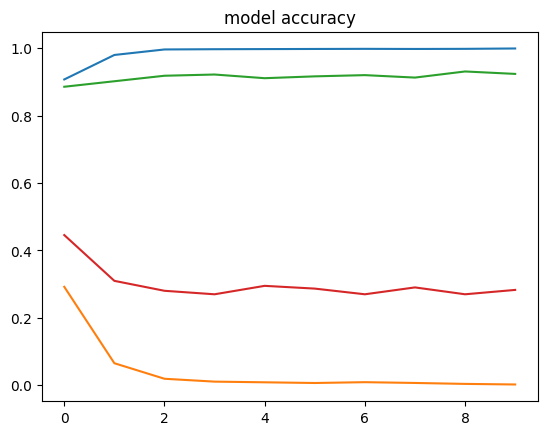

In [31]:
import matplotlib.pyplot as plt
plt.plot(history.history["accuracy"])
plt.plot(history.history["loss"])
plt.plot(history.history["val_accuracy"])
plt.plot(history.history["val_loss"])
plt.title("model accuracy")